<a href="https://colab.research.google.com/github/anilaq/capstone/blob/master/final_mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Recommendation System for Anime

Anime, is a hand drawn and computer animation originating from Japan which is widely drawn a cult following around the world. The animation industry consists of more than 430 companies. Some of the most popular anime that has come to Western television is Pokemon and Yugi-Oh ."Spirited Away" a film created by Hayao Miyazaki and animated by Studio Ghibli is the highest grossing film within the anime genre. The reason it became so popular in the west is because a good friend of Miyazaki convinced him to sell distribution rights to Walt Disney. Like Spirited Away, there are thousands of really good anime films and shows produced by the same animation house. Due to the pandemic a nice way to bring such works of art into Disney plus or any streaming site in the West I have created a recommendation system that can help anyone or any company to view/add the highest rated anime. The Japan External Trade Organization has valued overseas sales to  18𝑏𝑖𝑙𝑙𝑖𝑜𝑛( 5.2 billion for the US alone) in 2004. This has likely grown. With covid19 looming over Japan which has caused one of the first long term recessions for the country. A way at which potential growth could take place is focusing on streaming and producing more of the top recommended. 

In [0]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673635 sha256=8aa528125cb290d2a934a4374691074e80b2201b87a4a9d6604d2b61a699602a
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import pandas as pd 

import numpy as np 

import random
from random import randint

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds 

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline

from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD

from surprise.similarities import cosine, msd, pearson

from surprise import accuracy 
from surprise import Reader
from surprise import Dataset
from surprise import dataset



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing

In [0]:
anime_df = pd.read_csv('./anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [0]:
anime_df.shape

(12294, 7)

In [0]:
anime_df.dropna(inplace=True)

*** There are 12,294 rows above, and need to drop any null values ***

In [0]:
anime_df.shape #this seemed to have reduced it down a bit

(12017, 7)

## What each column represents: 
***anime_id: id number for each anime title***<br>
***name:  title of the motion picture***<br>
***genre:  category***<br>
***type:  describes the anime into tv, movies, OVA, and 3 other categories***<br>
***episodes: total number of episodes ***<br>
***rating: -1-10, lowest to highest*** <br>
***members:  number of community members that are in this anime group***<br>

In [0]:
anime_df.info() #having a look at all of the columns and types from the above cell and current to remove 
#any unneccessary extraneous data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


In [0]:
rating_df = pd.read_csv('./rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## What each column represents: 
*** user_id: non-identifiable randomly generated user id*** <br>
*** anime_id: the anime that the user has rated *** <br>
*** rating: rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating) ***

In [0]:
rating_df.shape

(2402463, 3)

Need to join both datasets together, will join using anime_id then hopefully will reshuffle the dataset so that it can be transformed into something that is compatible with `surprise`. 

I will join the two dataframes by merging them so that they can correspond to the correct anime_ids

In [0]:
df_merge = pd.merge(anime_df, rating_df, on = 'anime_id')
df_merge.head()
# df_merge = df_row.merge(rating_df, left_on= 'anime_id', how='outer')
# df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [0]:
df_merge.shape 

(2402411, 9)

*** The data here is extremely large. Because I will be using Singular Value Decomposition (SVD) which is known to be computationally expensive I will be taking a large sample from the 7.8 million rows. Before taking a sample I will remove the -1 ratings from the dataset since these don't really count as reviews ***

In [0]:
df_merge.rating_x.min()

2.0

In [0]:
df_merge = df_merge[df_merge.rating_y != -1]
df_merge.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10


In [0]:
df_merge.shape #have removed over 1 million rows

(1950639, 9)

In [0]:
sample = df_merge.sample(frac=.25)
sample.shape # this is still too large

(487660, 9)

In [0]:
sample = df_merge.sample(n=5000)
sample.shape #below I conduct SVD and it cannot handle anything larger than 5000 (i've tried)

(5000, 9)

###It seems that the rating dataframe is based on each user and their individual rating for each anime id, whereas the anime dataframe is an average overall rating from all of its viewers.  

In [0]:
#we are going to look at how many times each rating appears in a column
ratings_x = sample['rating_x'].value_counts() #continuous 
ratings_y = sample['rating_y'].value_counts() #discrete

print(ratings_x)
print(ratings_y)

7.70    58
7.55    57
7.95    57
7.81    56
7.43    53
        ..
5.06     1
5.80     1
5.79     1
3.68     1
5.73     1
Name: rating_x, Length: 333, dtype: int64
8     1281
7     1054
9     1021
10     747
6      552
5      204
4       71
3       32
2       24
1       14
Name: rating_y, dtype: int64


In [0]:
sample.rating_x = sample.rating_x.apply(round) #another important feature i have had to add is making all ratings discrete for SVD
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
354909,22145,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",TV,10,8,122895,20500,7
1343376,98,Mai-HiME,"Action, Comedy, Drama, Fantasy, Magic, Mecha, ...",TV,26,8,76492,11385,8
553228,2952,Final Fantasy VII: Advent Children Complete,"Action, Fantasy, Super Power",OVA,1,8,77111,15093,8
1342255,3392,Kiniro no Corda: Primo Passo - Hitonatsu no En...,"Harem, Music, Romance, School, Shoujo",Special,1,8,17967,5943,8
848436,1818,Claymore,"Action, Adventure, Demons, Fantasy, Shounen, S...",TV,26,8,316853,13569,9


## Distribution of User Ratings

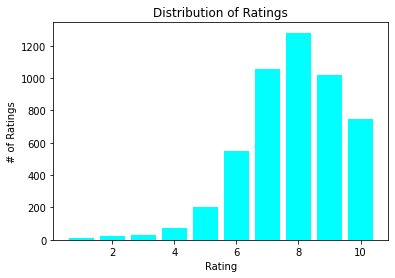

In [0]:
# plot distribution in matplotlib
ratings_sorted = sorted(list(zip(ratings_y.index, ratings_y)))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='cyan')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

In [0]:
#number of users
print("Number of Users:", df_merge.user_id.nunique())
# print("Average Number of Reviews per User:", df_merge.shape[0])/df_merge.user_id.nunique()
avg_rate_peruser = df_merge.shape[0]
user = df_merge.user_id.nunique()
avg_num_review_per_user = avg_rate_peruser/user
print("Average Number of Reveiws per User:", avg_num_review_per_user)

Number of Users: 21710
Average Number of Reveiws per User: 89.84979272224781


In [0]:
sample['user_id'].value_counts()

7345     9
11536    8
20766    7
6969     7
21588    7
        ..
10463    1
11178    1
4776     1
13803    1
16384    1
Name: user_id, Length: 3735, dtype: int64

## Number of Reviews per User

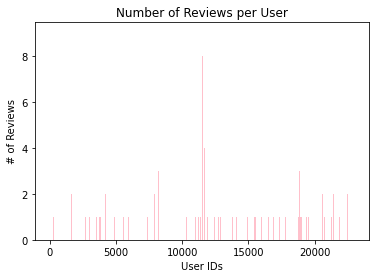

In [0]:
ratings_per_user = sample['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user], color='pink')
plt.xlabel('User IDs')
plt.ylabel('# of Reviews')
plt.title('Number of Reviews per User')
plt.show()

In [0]:
#graph on user ratings, what are the most common scores given 

## Different types of anime videos

In [0]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())
print("Types of type:", sample.type.value_counts())

Number of users: 3735
Number of types of different anime: 6
Types of type: TV         3424
Movie       690
OVA         475
Special     339
ONA          54
Music        18
Name: type, dtype: int64


This means that there are six different categories for anime: <br>
Movies, TV, OVA, Special, ONA and Music. <br>
***OVA stands for orginal animation video, this has been released directly to the video market <br>
Special is not a common occuring video, it is usually shot yearly or on a one off <br>
Music is not just audio here, but a lively animated motion picture to go with the composed music piece ***

In [0]:
sample_of_sample = sample[:100] #taking a sample to see if its the amount of data or its the command given
sample_of_sample

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
354909,22145,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",TV,10,8,122895,20500,7
1343376,98,Mai-HiME,"Action, Comedy, Drama, Fantasy, Magic, Mecha, ...",TV,26,8,76492,11385,8
553228,2952,Final Fantasy VII: Advent Children Complete,"Action, Fantasy, Super Power",OVA,1,8,77111,15093,8
1342255,3392,Kiniro no Corda: Primo Passo - Hitonatsu no En...,"Harem, Music, Romance, School, Shoujo",Special,1,8,17967,5943,8
848436,1818,Claymore,"Action, Adventure, Demons, Fantasy, Shounen, S...",TV,26,8,316853,13569,9
...,...,...,...,...,...,...,...,...,...
412392,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8,283069,2712,8
855230,4472,Lucky☆Star: Original na Visual to Animation,"Comedy, Parody, School, Slice of Life",OVA,1,8,84833,7581,8
2054497,936,Naruto Movie 2: Dai Gekitotsu! Maboroshi no Ch...,"Adventure, Comedy, Drama, Fantasy, Shounen, Su...",Movie,1,7,97308,7116,5
624538,14813,Yahari Ore no Seishun Love Comedy wa Machigatt...,"Comedy, Drama, Romance, School",TV,13,8,353876,3453,8


In [0]:
sample.loc[sample['type'] == 'Movie']

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
1643125,1526,Pokemon Advanced Generation: Mew to Hadou no Y...,"Action, Adventure, Drama, Fantasy, Kids",Movie,1,7,46887,1309,7
1958460,903,Dragon Ball Z Movie 10: Kiken na Futari! Super...,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",Movie,1,7,54947,7580,5
1059772,9000,Toaru Hikuushi e no Tsuioku,"Adventure, Military, Romance",Movie,1,8,28857,21211,9
1916453,3745,Crayon Shin-chan Movie 02: Buriburi Oukoku no ...,"Comedy, Ecchi, Kids, School, Shounen, Slice of...",Movie,1,7,2073,1900,7
377323,1033,Sennen Joyuu,"Action, Adventure, Drama, Fantasy, Historical,...",Movie,1,8,58492,5314,7
...,...,...,...,...,...,...,...,...,...
1737538,1901,11-nin Iru!,"Action, Adventure, Drama, Mystery, Romance, Sc...",Movie,1,7,4311,5899,7
191275,3784,Evangelion: 2.0 You Can (Not) Advance,"Action, Mecha, Sci-Fi",Movie,1,9,182224,2407,1
528917,1430,Lupin III: Cagliostro no Shiro,"Adventure, Comedy, Shounen",Movie,1,8,32732,3426,6
75419,164,Mononoke Hime,"Action, Adventure, Fantasy",Movie,1,9,339556,19777,10


In [0]:
len(sample.loc[sample['type'] == 'TV']) #How many tv shows there are in the dataframe

3424

In [0]:
len(sample.loc[sample['type'] == 'Movie'])

690

In [0]:
sample.loc[sample['type'] == 'Movie'].rating_x.value_counts() #Viewer ratings for films 

8    425
7    167
9     85
6     11
4      2
Name: rating_x, dtype: int64

In [0]:
sample.loc[sample['type'] == 'Movie'].rating_y.value_counts() #Viewer ratings for films 

8     184
7     151
9     139
10    110
6      67
5      29
4       3
2       3
1       3
3       1
Name: rating_y, dtype: int64

***drop rows containing -1 as rating in df_merge ***
could be that I have an approximation error 

*** Look at min ratings in rating_x *** if its a rating error, we would recreate y based off of x. (round to a whole number) *** 0 decimal places

## Most Reviewed Videos

In [0]:
movies_review = len(sample.loc[sample['type'] == 'Movie'])
movies_review

690

In [0]:
tv_reviews = len(sample.loc[sample['type'] == 'TV'])
tv_reviews

3424

In [0]:
ova_reviews = len(sample.loc[sample['type'] =='OVA'])
ova_reviews

475

In [0]:
music_reviews = len(sample.loc[sample['type'] =='Music'])
music_reviews

18

In [0]:
ona_reviews = len(sample.loc[sample['type'] =='ONA'])
ona_reviews

54

In [0]:
special_reviews = len(sample.loc[sample['type'] =='Special'])
special_reviews

339

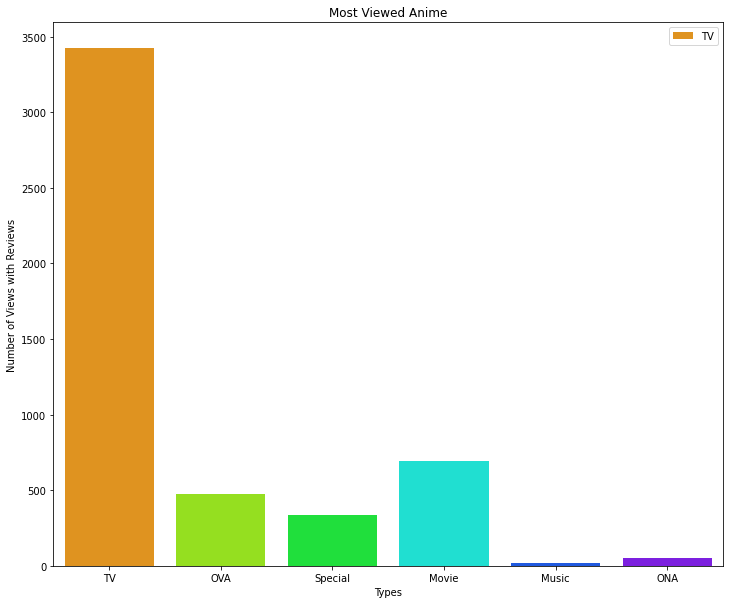

In [0]:
# PLOT them 
fig = plt.figure(figsize=(12,10))
sns.countplot(sample['type'], palette='gist_rainbow')
plt.title("Most Viewed Anime")
plt.xlabel("Types")
plt.ylabel("Number of Views with Reviews")
plt.legend(sample['type'])
plt.show()

In [0]:
len(sample)

5000

# Implementing a Surprise's Singular Value Decomposition (SVD) as a Baseline

In [0]:
sample.rating_x = sample.rating_x.apply(round)
sample.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
4345477,356,Fate/stay night,"Action, Fantasy, Magic, Romance, Supernatural",TV,24,8,374880,22158,9
4192888,1195,Zero no Tsukaima,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,13,8,346828,36587,5
5380692,152,Solty Rei,"Action, Sci-Fi, Super Power",TV,24,7,17943,29858,8
5095893,27,Trinity Blood,"Action, Supernatural, Vampire",TV,24,7,113791,31849,7
7276500,31121,Monster Musume no Iru Nichijou: Hobo Mainichi ...,"Comedy, Slice of Life",ONA,60,7,13801,34071,9


In [0]:
#for surprise, it likes its data in a certain way and only that specific data
data = sample[['user_id', 'anime_id', 'rating_x']] #may need to do rating_x rounded and then use rating_y
reader = Reader(line_format='user item rating', sep='')
anime_loaded_data = Dataset.load_from_df(data, reader)
# anime_split = anime_loaded_data.split(n_folds=5) 

#train_test_split
trainset, testset = train_test_split(anime_loaded_data, test_size=.2)

In [0]:
anime_loaded_data

In [0]:
#INSTANTIATE the SVD and fit only the train set
svd = SVD()
svd.fit(trainset)

In [0]:
predictions = svd.test(testset) #
accuracy.rmse(predictions)

RMSE: 2.7731


2.7730849247724096

*** I don't think this is better than the .66 that I have above on the memory based models.***

In [0]:
predictions[:10]

[Prediction(uid=27058, iid=3572, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=38620, iid=13667, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=29646, iid=31376, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=5296, iid=1108, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=50977, iid=690, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=52361, iid=5955, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=16744, iid=8536, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=33730, iid=18881, r_ui=6.0, est=5, details={'was_impossible': False}),
 Prediction(uid=18091, iid=2112, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=12710, iid=22729, r_ui=8.0, est=5, details={'was_impossible': False})]

In [0]:
print("Number of users:", sample.user_id.nunique())
print("Number of types of different anime:", sample.type.nunique())


Number of users: 4480
Number of types of different anime: 6


In [0]:
user = 5
item = 100
svd.predict(user, item)

Prediction(uid=5, iid=100, r_ui=None, est=5, details={'was_impossible': False})

Now I need to compare the different models and see which ones perform best. I will stick to using RMSE to evaluate the models. I will also cross validate. 

In [0]:
#perform a gridsearch CV
params = {'n_factors': [20,50,100],
         'reg_all': [.02,.05, .10]}
gridsearch_svd1 = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=3)
gridsearch_svd1.fit(anime_loaded_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.8s finished


In [0]:
print(gridsearch_svd1.best_score)
print(gridsearch_svd1.best_params)

{'rmse': 2.7752982992400335, 'mae': 2.6844}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


**Better than the model before***

In [0]:
anime_loaded_data

## Cross Validation with K-Nearest Neighbors (KNN) Basic Algorithm

In [0]:
#cross validate with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=True)
cv_knn_basic = cross_validate(knn_basic, anime_loaded_data, n_jobs=2)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([2.79123629, 2.75245345, 2.75680975, 2.78513913, 2.79105715]))
('test_mae', array([2.701, 2.662, 2.664, 2.691, 2.704]))
('fit_time', (1.544229507446289, 1.610764980316162, 1.0170748233795166, 1.017421007156372, 0.5036599636077881))
('test_time', (0.012166976928710938, 0.012871265411376953, 0.01230168342590332, 0.012347936630249023, 0.007039785385131836))
-----------------
2.7753391537641336


*** This is not as good as the baseline***

In [0]:
knn_basic_msd = KNNBasic(sim_options = {'name': 'msd', 'user-based':True})
cv_knn_basic_msd = cross_validate(knn_basic_msd, anime_loaded_data, n_jobs=2)

In [0]:
for i in cv_knn_basic_msd.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_basic_msd['test_rmse']))

('test_rmse', array([2.79427987, 2.76676707, 2.77758888, 2.78801004, 2.75009091]))
('test_mae', array([2.708, 2.675, 2.687, 2.695, 2.657]))
('fit_time', (0.6251428127288818, 0.7191717624664307, 0.73598313331604, 0.6341302394866943, 0.4385659694671631))
('test_time', (0.011588096618652344, 0.015184879302978516, 0.012300968170166016, 0.012490987777709961, 0.01270914077758789))
-----------------
2.775347354196228


*** better than the model above ***


## Cross Validation with KNN Baseline

In [0]:
#cross validate with KNN Baseline (pearson)
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, anime_loaded_data, n_jobs=3)

In [0]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([2.77362579, 2.75916654, 2.77740886, 2.77254396, 2.79410093]))
('test_mae', array([2.681, 2.669, 2.682, 2.679, 2.711]))
('fit_time', (1.0227296352386475, 1.4636266231536865, 1.6993529796600342, 1.290511131286621, 0.9127292633056641))
('test_time', (0.011719226837158203, 0.018441438674926758, 0.007163524627685547, 0.026695728302001953, 0.011332511901855469))
-----------------
2.775369215598489


***better than the other rmse but not as good as mae from above *** 

In [0]:
knn_baseline_msd = KNNBaseline(sim_options = {'name': 'msd', 'user_based': True})
cv_knn_baseline_msd = cross_validate(knn_baseline_msd, anime_loaded_data, n_jobs =2)

In [0]:
for i in cv_knn_baseline_msd.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_baseline_msd['test_rmse']))

('test_rmse', array([2.74390233, 2.78100701, 2.75789775, 2.80446073, 2.78926514]))
('test_mae', array([2.653, 2.694, 2.666, 2.715, 2.694]))
('fit_time', (2.6375131607055664, 1.2855372428894043, 1.4467082023620605, 1.287856101989746, 0.9131350517272949))
('test_time', (0.026901721954345703, 0.027647972106933594, 0.02987837791442871, 0.023685932159423828, 0.012809514999389648))
-------------------
2.7753065922503595


*** Not as good as the above ***

## Cross Validate with KNNBaseline using pearson baseline

In [0]:
knn_pearson_baseline = KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based':True})
cv_knn_pearson_baseline = cross_validate(knn_pearson_baseline, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_pearson_baseline.items():
  print(i)
print('-------------------')
print(np.mean(cv_knn_pearson_baseline['test_rmse']))

('test_rmse', array([0.62452546, 0.5997821 , 0.5939826 , 0.61225689, 0.57804702]))
('test_mae', array([0.48127915, 0.48513377, 0.46955166, 0.48101584, 0.46973202]))
('fit_time', (1.3529422283172607, 1.0419158935546875, 1.4332692623138428, 0.7306246757507324, 0.6215074062347412))
('test_time', (0.011812448501586914, 0.02728867530822754, 0.00835561752319336, 0.012857675552368164, 0.026695728302001953))
-------------------
0.6017188137950151


*** hmmmm... this is a realistic number for an average rmse score but varies greatly from the other scores, looks similar to the models I added in at the top ***

## KNN with Means 

In [0]:
knn_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
cv_knn_means = cross_validate(knn_means, anime_data, n_jobs=3)

In [0]:
for i in cv_knn_means.items():
  print(i)
print('------------')
print(np.mean(cv_knn_means['test_rmse']))

('test_rmse', array([0.75678008, 0.79129836, 0.78972301, 0.79741875, 0.80765812]))
('test_mae', array([0.60560408, 0.61820883, 0.62189   , 0.63303117, 0.6407105 ]))
('fit_time', (0.9913804531097412, 0.930255651473999, 1.7804861068725586, 1.0836842060089111, 0.891467809677124))
('test_time', (0.026706933975219727, 0.014213323593139648, 0.007684469223022461, 0.012784957885742188, 0.013603687286376953))
------------
0.7885756633471485


In [0]:
knn_means_msd = KNNWithMeans(sim_options={'name': 'msd', 'user_based':True})
cv_knn_means_msd = cross_validate(knn_means_msd, anime_data, n_jobs = 2)

In [0]:
for i in cv_knn_means_msd.items():
  print(i)
print('-------------')
print(np.mean(cv_knn_means_msd['test_rmse']))

('test_rmse', array([0.80126757, 0.75017143, 0.80965893, 0.78969954, 0.77894254]))
('test_mae', array([0.63284583, 0.59925983, 0.64980933, 0.62745175, 0.61390783]))
('fit_time', (0.6287145614624023, 0.6414694786071777, 0.7459201812744141, 0.6342384815216064, 0.3879835605621338))
('test_time', (0.01252126693725586, 0.021621227264404297, 0.012741327285766602, 0.013233423233032227, 0.0070667266845703125))
-------------
0.7859480012061154


*** This is a lot better than the KNNBaseline ***

## Tuning the Best Algorithm with GridSearchCV
Best model so far is KNN Baseline with Mean Squared Distance

In [0]:
param_grid = {'n_factors': [5, 20, 100], 
              'n_epochs': [5,10], 
              'lr_all': [.002, .005], 
              'reg_all': [.02, .05, .5]}
knn_withmeans_gs = GridSearchCV(KNNWithMeans, param_grid=param_grid, n_jobs=3, joblib_verbose=3)
knn_withmeans_gs.fit(anime_data)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   11.0s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   48.7s
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:  1.2min finished


In [0]:
print(knn_baseline_gs.best_score)
print(knn_baseline_gs.best_params)

{'rmse': 0.6013752188370415, 'mae': 0.4770148147495893}
{'rmse': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}, 'mae': {'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.02}}


In [0]:
#Now use this to fit test set, initial gridsearch was 2.77096, so will use that gs here
highest_perf_algo = gridsearch_svd1.best_estimator['rmse']

In [0]:
#retrain the whole set
trainset = anime_data.build_full_trainset()
highest_perf_algo.fit(trainset)

In [0]:
#Biased Accuracy on trainset
predictions = highest_perf_algo.test(trainset.build_testset())
print('Biased accuracy on Trainset', end='')
accuracy.rmse(predictions)

Biased accuracy on TrainsetRMSE: 0.4427


0.4426835056532015

In [0]:
#UnBiased Accuracy on testset
predictions = highest_perf_algo.test(testset)
print('Unbiased Accuracy on test', end='')
accuracy.rmse(predictions)

Unbiased Accuracy on testRMSE: 0.5430


0.5430297500386062

# Collaborative Models

In [0]:
class MyDataset(dataset.DatasetAutoFolds):
  #surprise.dataset.DatasetAutoFolds creates a surprise friendly dataset
  #this will give it folds so that cross validation can be performed efficiently
  def __init__(self, sample, reader):
    self.sample = [(uid, iid, r, None) for (uid, iid, r) in 
                   zip (sample['user_id'], sample['anime_id'], sample['rating_x'])]
    self.reader = reader

In [0]:
# #instantiate the reader parser object
#reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))

In [0]:
# #parse sample set into a surprise friendly dataset
#data = MyDataset(sample, reader)

In [0]:
reader = Reader(line_format = 'user item rating', rating_scale = (0.0, 10.0))
data = sample[['user_id', 'anime_id', 'rating_x']]
anime_data = Dataset.load_from_df(data, reader)

In [0]:
type(data)

pandas.core.frame.DataFrame

# Train Validation Split

In [0]:
trainset, testset = train_test_split(anime_data, test_size=.2)

# Memory Based Knn Method

## KNN Basic with cosine similarity

In [0]:
#cosine similarity 
sim_cos = {'name': 'cosine', 'user_based':True}

#instantiate the model with the similarity setting
knn_sim_cos = knns.KNNBasic(sim_options=sim_cos)

In [0]:
# fit the model
sim_cos_cv = cross_validate(knn_sim_cos, anime_data, measures=['rmse', 'mae'], cv=3,
                            return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6978  0.7335  0.7011  0.7108  0.0161  
MAE (testset)     0.5817  0.6068  0.5786  0.5890  0.0126  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.83    0.66    0.61    0.70    0.10    
Test time         0.04    0.03    0.04    0.04    0.00    


*** 

### The test set is not great but not terribly bad. I am not sure why the train set is not showing up. 

## 2nd Model: KNN Basic (item based)

In [0]:
#cosine similarity 
sim_cos = {'name': 'cosine', 'user_based': False}

#instantiate the knnBasic with sim_cos settings
knn_basic_simcos = knns.KNNBasic(sim_options=sim_cos)


In [0]:
#fit the model 
cv_knn_basic_simcos = cross_validate(knn_basic_simcos, anime_data, measures=['rmse', 'mae'], cv =3, return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6938  0.7346  0.7039  0.7108  0.0174  
MAE (testset)     0.5809  0.5984  0.5874  0.5889  0.0072  
RMSE (trainset)   0.1968  0.2038  0.2012  0.2006  0.0029  
MAE (trainset)    0.0519  0.0560  0.0571  0.0550  0.0022  
Fit time          0.20    0.16    0.07    0.14    0.05    
Test time         0.02    0.02    0.01    0.02    0.00    


In [0]:
#This one performed better than the last and the trainset is showing up. WOOH!

##3rd Baseline Model: A user based pearson similarity using KNNBasline

In [0]:
sim_pearson = {'name': 'pearson', 'user_based': True}

#instantiate KNNBasline with pearson 
knn_baseline_pearson = knns.KNNBaseline(sim_options=sim_pearson)

In [0]:
#fit and cross validate model 
cv_knnbaseline_simpearson = cross_validate(knn_baseline_pearson, anime_data, measures=['rmse', 'mae'], cv=3,
                                           return_train_measures=True, n_jobs=2, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6121  0.6140  0.5889  0.6050  0.0114  
MAE (testset)     0.4892  0.4978  0.4753  0.4874  0.0093  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.60    0.68    0.46    0.58    0.09    
Test time         0.02    0.02    0.01    0.02    0.00    


### This user based model with sim pearson did not do as well. Again, user based does not produce trainset results

## 4th Model: Item based pearson similarity using KNNBaseline

In [0]:
sim_pearson = {'name':'pearson', 'user_based': False}

#instantiate KNNBasline 
knn_baseline_item = knns.KNNBaseline(sim_options=sim_pearson)

In [0]:
#fit and cross validate
cv_knnbaseline_item = cross_validate(knn_baseline_item, anime_data, measures=['rmse', 'mae'], cv=3, 
                                     return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6223  0.5863  0.6037  0.6041  0.0147  
MAE (testset)     0.4878  0.4793  0.4919  0.4863  0.0052  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.19    0.17    0.14    0.17    0.02    
Test time         0.02    0.02    0.01    0.02    0.00    


### This model hasn't performed well and also for some reason has not given trainset RMSE and MAE

## 5th Model: User based using KNNWithMeans with pearson 

In [0]:
sim_pearson = {'name': 'pearson', 'user_based': True}

#instantiating KNNWithMeans
knn_withmeans_user = knns.KNNWithMeans(sim_options=sim_pearson)

In [0]:
#fit and cross validate 
cv_knnwithmeans_user = cross_validate(knn_withmeans_user, anime_data, measures=['rmse','mae'], cv=3, return_train_measures=True, 
                                      n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7488  0.7431  0.7587  0.7502  0.0065  
MAE (testset)     0.6080  0.6046  0.6037  0.6054  0.0019  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.72    0.83    0.76    0.77    0.05    
Test time         0.03    0.02    0.01    0.02    0.01    


#### This test set has the best performance yet, but no idea why the trainset is not showing up. 

## 6th Model: KNNWithMeans but item based

In [0]:
sim_pearson = {'name': 'pearson', 'user_based':False}

#instantiate 
knn_withmeans_item = knns.KNNWithMeans(sim_options=sim_pearson)


In [0]:
#fit and cross validate
cv_knnwithmeans_item = cross_validate(knn_withmeans_item, anime_data, measures=['rmse', 'mae'], cv=3,
                                      return_train_measures=True, n_jobs=3, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6776  0.6693  0.6955  0.6808  0.0109  
MAE (testset)     0.5361  0.5288  0.5462  0.5370  0.0071  
RMSE (trainset)   0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (trainset)    0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.22    0.19    0.14    0.18    0.03    
Test time         0.02    0.02    0.01    0.02    0.00    


#### The item based for pearson on the KNNWithMeans does not perform as well

# Model Based Methods

## Alternating Least Squares

### 7th Model with hyperparameter tuning

In [0]:
# create parameter permutations
epochs = [3, 5, 10, 20]
reg_u = [5, 10, 12, 15, 20]
reg_i = [3, 5, 10, 15]

params = [[i, j, k] for i in epochs
          for j in reg_u
          for k in reg_i]
print('Number of grid search permutation:', len(params))


Number of grid search permutation: 80


In [0]:
baseline_option_score = {}

for basline_perm in params: 
  basline_options = {'method': 'als',
                     'n_epochs': bsl_perm[0],
                     'reg_u': bsl_perm[1],
                     'reg_i': bsl_perm[2]}
  #instantiate
  algo = baseline_only.BaselineOnly(bsl_options=baseline_options)
  #fit and cross validate
  cv_algo = cross_validate(algo, anime_data, measures=['rmse', 'mae'], cv =3, 
                           verbose = False, return_train_measures=True);
  bsl_perm2 = (str(bsl_perm[0]) + ' ' + str(bsl_perm[1]) + ' ' + str(bsl_perm[2]))
  baseline_option_score[bsl_perm2] = {'mean_train_rmse': cv_algo['train_rmse'].mean(), 'mean_test_rmse': a['test_rmse'].mean()}

  #print('\n', baseline_options, '\n', '\n\')

NameError: ignored

# WILL NOT CONTINUE USING PYSPARK! JUST REMEMBERED THAT THE LEARNCO IS OUTDATED

# Pyspark 

In [0]:
!pip install pyspark

In [0]:
from pyspark.sql import SparkSession 

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [0]:
#instantiate SparkSession object 
spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [0]:
sample.to_csv('sample.csv', index='False')

In [0]:
#read in data into pyspark dataframe
sample = spark.read.csv('./sample.csv', header='true', inferSchema='true')

## Fitting the Alternating Least Squares Model

In [0]:
from pyspark.ml.tuning.TrainValidationSplit


In [0]:
#TRAIN TEST SPLIT
trainset, testset = anime_loaded_data.randomSplit([.8, .2])

In [0]:
#Build a recommendation model using ALS on the training data
als = ALS(maxIter=5,
         rank=4, 
         regParam=.01, 
         userCol='user_id',
         itemCol='anime_id',
         ratingCol='rating',
         coldStartStrategy='drop')
#fit the ALS to training set
als_model = als.fit(trainset)

In [0]:
#Let's evaluate its performance, above with surprise we got an unrealistic RMSE of 2.75
#start wtih a regression evaluator
from pyspark.ml.evaluation import RegressionEvaluator 
#let's compute the ALS RMSE on the testset
predictions = als_model.transform(testset)
evaluator = RegressionEvaluator(metricName='rmse',
                               labelCol='rating',
                               predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print("Root Mean Square Error:", str(rmse))


## Cross Validation to find the optimal model 